In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
import seaborn as sns
import matplotlib.pyplot as plt 
from keras_tuner.tuners import RandomSearch
#import hiplot as hip
#conda install -c conda-forge hiplot
from keras.utils.vis_utils import plot_model

In [2]:
# pip install keras_tuner

In [3]:
print(tf.__version__)

2.8.0


In [4]:
url = 'https://raw.githubusercontent.com/GangababuGB/Public/master/IOT_DS_ALGORITHM/IOT_Anamoly_M1/sensor_IOT_ok.csv'
df = pd.read_csv(url)
df.tail(5)

,TS,xs1,xs2,xs3,xs4,xs5,xs6,xs7,xs8,label
11143,03/09/2022 05:30:38 PM,22.360545,62.441708,614.275778,91.316984,111.261258,337.652206,608.626105,93.236732,0
11144,03/09/2022 05:30:39 PM,22.378963,60.832924,615.603485,90.670284,111.390261,338.368133,614.853440,92.449471,3
11145,03/09/2022 05:30:40 PM,22.115642,61.879360,603.981455,92.154777,111.429463,335.943793,619.911271,93.524759,0
11146,03/09/2022 05:30:41 PM,21.294801,60.977528,606.264567,92.715570,111.441063,339.222134,601.457418,92.225605,0
11147,03/09/2022 05:30:42 PM,21.655784,60.989786,602.392391,92.910869,111.520200,333.786280,601.532498,91.121459,0


In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TS,11148,11148,03/09/2022 02:17:13 PM,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
xs1,11148.0,NaN,NaN,NaN,21.54897,0.583528,20.550409,21.052107,21.537718,22.045423,27.839009
xs2,11148.0,NaN,NaN,NaN,61.546329,0.593023,60.550082,61.036585,61.547124,62.039461,66.873661
xs3,11148.0,NaN,NaN,NaN,610.536744,5.82749,600.551494,605.581675,610.43256,615.454066,672.973467
xs4,11148.0,NaN,NaN,NaN,92.067083,0.891504,90.550414,91.310898,92.071592,92.82138,99.324656
xs5,11148.0,NaN,NaN,NaN,111.045578,0.288501,110.550006,110.795257,111.046586,111.291546,111.549988
xs6,11148.0,NaN,NaN,NaN,340.588304,5.756236,330.550856,335.608906,340.589028,345.579716,354.891147
xs7,11148.0,NaN,NaN,NaN,610.587991,5.821717,600.552907,605.636415,610.529193,615.520487,669.978879
xs8,11148.0,NaN,NaN,NaN,92.044615,0.883438,90.550388,91.288106,92.035702,92.790584,99.802652
label,11148.0,NaN,NaN,NaN,0.662002,1.807662,0.0,0.0,0.0,0.0,8.0


In [6]:
#df.set_index('TS', inplace = True)

In [7]:
#Drop time - Interpret as part of model
df = df.drop("TS", axis = 1)

In [8]:
df.skew().sort_values(ascending=False)

label    2.805029
xs2      0.377692
xs4      0.323413
xs8      0.304086
xs7      0.262329
xs3      0.261782
xs1      0.180545
xs5      0.012289
xs6     -0.005937
dtype: float64

In [9]:
df.kurt().sort_values(ascending=False)

label    6.787438
xs2      1.694047
xs7      1.296335
xs3      1.062812
xs4      0.984761
xs8      0.919190
xs1      0.349930
xs6     -1.197418
xs5     -1.197700
dtype: float64

In [10]:
# No strong correlations
df.corr()['label'].sort_values()

xs6     -0.012780
xs7     -0.006681
xs3      0.000711
xs1      0.000772
xs5      0.011555
xs2      0.017917
xs4      0.024305
xs8      0.039384
label    1.000000
Name: label, dtype: float64

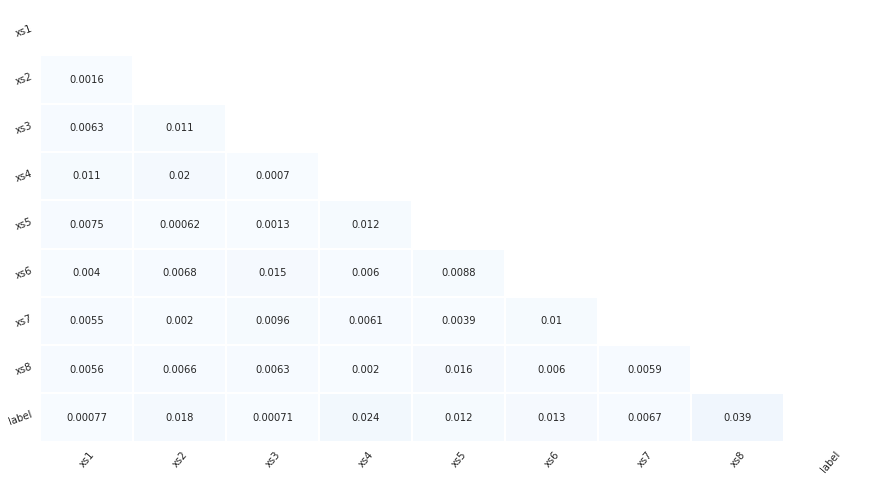

In [11]:
# No correlation between Principal Components as expected
corr = abs(df.corr()) # correlation matrix
lower_triangle = np.tril(corr, k = -1)  # select only the lower triangle of the correlation matrix
mask = lower_triangle == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
sns.heatmap(lower_triangle, center=0.5, cmap= 'Blues', annot= True, xticklabels = corr.index, yticklabels = corr.columns,
            cbar= False, linewidths= 1, mask = mask,fmt='.2g')   # Da Heatmap
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

In [12]:
df.columns

Index(['xs1', 'xs2', 'xs3', 'xs4', 'xs5', 'xs6', 'xs7', 'xs8', 'label'], dtype='object')

In [13]:
# Check distributions for Class 0 vs 1
normal = df[df.label==0]
aly_xs1 = df[df.label==1]
aly_xs2 = df[df.label==2]
aly_xs3 = df[df.label==3]
aly_xs4 = df[df.label==4]
aly_xs5 = df[df.label==5]

In [14]:
normal.describe().T

,count,mean,std,min,25%,50%,75%,max
xs1,9477.0,21.546583,0.579211,20.550409,21.050352,21.538258,22.045631,22.549948
xs2,9477.0,61.539839,0.578529,60.550082,61.034255,61.541243,62.035493,62.549886
xs3,9477.0,610.525160,5.747481,600.551494,605.568084,610.457642,615.460719,620.538192
xs4,9477.0,92.056988,0.865226,90.550414,91.300789,92.073395,92.813011,93.549672
xs5,9477.0,111.043971,0.287700,110.550066,110.793245,111.043820,111.287151,111.549939
xs6,9477.0,340.603156,5.739649,330.550856,335.618819,340.601903,345.590307,350.548966
xs7,9477.0,610.608239,5.745124,600.552907,605.664709,610.567268,615.610069,620.549196
xs8,9477.0,92.033245,0.863429,90.550388,91.283488,92.023242,92.785394,93.549707
label,9477.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
aly_xs1.describe().T

,count,mean,std,min,25%,50%,75%,max
xs1,222.0,21.621950,0.788025,20.578535,21.122580,21.553493,22.036891,27.839009
xs2,222.0,61.568897,0.578816,60.569103,61.012771,61.647374,62.076545,62.546528
xs3,222.0,610.494692,5.923802,600.556646,605.693508,610.497367,615.874176,620.080832
xs4,222.0,92.094067,0.880942,90.554565,91.343565,92.126839,92.871779,94.467974
xs5,222.0,111.067987,0.295759,110.554449,110.828574,111.090638,111.309920,111.549842
xs6,222.0,340.389347,5.635293,330.607748,336.132492,340.210703,345.099458,350.509710
xs7,222.0,610.925168,5.528953,600.699352,606.465808,610.903925,616.131916,620.485314
xs8,222.0,92.086708,0.832387,90.561614,91.368690,92.126209,92.797057,93.517701
label,222.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
aly_xs5.describe().T

,count,mean,std,min,25%,50%,75%,max
xs1,235.0,21.557788,0.578779,20.559286,21.064315,21.532330,22.084086,22.547837
xs2,235.0,61.577237,0.585159,60.582683,61.028447,61.526823,62.107132,62.542729
xs3,235.0,610.487905,6.221508,600.646461,605.065031,610.324552,615.838671,640.769065
xs4,235.0,92.084568,0.877038,90.559427,91.351051,92.043932,92.885817,93.534196
xs5,235.0,111.034620,0.289370,110.551314,110.772995,111.049469,111.290779,111.543442
xs6,235.0,340.663001,5.829233,330.570515,335.692032,340.431149,345.587054,350.540524
xs7,235.0,609.493586,5.968205,600.600622,604.287012,609.153894,614.635372,620.527113
xs8,235.0,91.964880,0.865867,90.550528,91.171760,91.979787,92.629775,93.541824
label,235.0,5.000000,0.000000,5.000000,5.000000,5.000000,5.000000,5.000000


# Split data into Train & Test Data for Modelling

In [17]:
X_data = df.iloc[:, :-1]

In [18]:
X_data.head()

,xs1,xs2,xs3,xs4,xs5,xs6,xs7,xs8
0,22.145063,61.341648,612.720965,92.263350,110.608746,336.532519,615.487047,93.092009
1,21.070552,61.936690,613.288690,92.296894,111.187354,345.557790,618.298205,93.236768
2,22.396227,62.394607,607.706115,92.674782,111.151746,340.013010,613.013097,90.599873
3,20.912552,61.453081,602.733841,90.756061,111.190299,347.828972,610.310325,92.562133
4,22.070204,62.131923,618.636366,92.325186,110.742548,334.120888,614.771046,91.960464


In [19]:
y_data = df.iloc[:, -1]

In [20]:
y_data.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [21]:
X_data.shape,y_data.shape

((11148, 8), (11148,))

In [22]:
y_data.value_counts()/y_data.shape[0]*100
#Imbalanced Dataset

0    85.010764
5     2.108001
1     1.991389
2     1.982418
4     1.937567
8     1.803014
6     1.749193
3     1.722282
7     1.695371
Name: label, dtype: float64

In [23]:
y_data.value_counts()

0    9477
5     235
1     222
2     221
4     216
8     201
6     195
3     192
7     189
Name: label, dtype: int64

In [24]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y_data = to_categorical(labelencoder.fit_transform(y_data))

In [25]:
y_data[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [26]:
y_data[11144]

array([0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [28]:
X_train = preprocessing.normalize(X_train)
X_test = preprocessing.normalize(X_test)

In [29]:
pd.DataFrame(X_train).describe().T

,count,mean,std,min,25%,50%,75%,max
0,8918.0,0.022773,0.000634,0.021212,0.022242,0.022767,0.023296,0.029365
1,8918.0,0.065059,0.000734,0.061919,0.064509,0.065063,0.065596,0.071195
2,8918.0,0.645289,0.004658,0.617871,0.641886,0.645241,0.648654,0.674428
3,8918.0,0.097312,0.001102,0.092715,0.096498,0.097322,0.098110,0.105367
4,8918.0,0.117375,0.000760,0.112484,0.116839,0.117371,0.117913,0.119755
5,8918.0,0.359972,0.005654,0.337346,0.355359,0.360014,0.364603,0.373827
6,8918.0,0.645352,0.004657,0.620630,0.641989,0.645379,0.648727,0.681357
7,8918.0,0.097292,0.001090,0.093427,0.096488,0.097290,0.098091,0.105653


In [30]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8918, 8)
(8918, 9)
(2230, 8)
(2230, 9)


# Creating a model
Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation

In [81]:
tf.keras.backend.clear_session()

In [82]:
model = Sequential()

# Adding layers [layers and activations]
Keras layers can be added to the model

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added

In [83]:
model.add(Dense(100, input_shape = (8,), activation = 'relu'))
model.add(Dense(200, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(9, activation = 'softmax'))
# method.add - add dense layer - fully connected, Play with ,kernel_initializer=,bias_initializer=

Model compile [optimizers and loss functions]

Keras model should be "compiled" prior to training

Types of loss (function) and optimizer should be designated

In [84]:
sgd = optimizers.Adam(learning_rate = 0.001)
#Optimization Function

In [87]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
# Loss for compare and gives us the error,

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               900       
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 9)                 909       
                                                                 
Total params: 42,109
Trainable params: 42,109
Non-trainable params: 0
_________________________________________________________________


## Training the model

In [89]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

#history = model.fit(X_train, y_train, batch_size = 700, epochs = 50, verbose = 1,validation_split=0.2)
# Training the model, You can use class_weight as a paramter for imbalanced here if no Over/Under Sampling performed

Epoch 1/100
271/279 [============================>.] - ETA: 0s - loss: 0.8240 - accuracy: 0.8436
Epoch 1: val_loss improved from inf to 0.71197, saving model to saved_models/audio_classification.hdf5
279/279 [==============================] - 3s 9ms/step - loss: 0.8256 - accuracy: 0.8428 - val_loss: 0.7120 - val_accuracy: 0.8570
Epoch 2/100
265/279 [===========================>..] - ETA: 0s - loss: 0.7441 - accuracy: 0.8486
Epoch 2: val_loss did not improve from 0.71197
279/279 [==============================] - 1s 3ms/step - loss: 0.7447 - accuracy: 0.8484 - val_loss: 0.7182 - val_accuracy: 0.8570
Epoch 3/100
268/279 [===========================>..] - ETA: 0s - loss: 0.7444 - accuracy: 0.8484
Epoch 3: val_loss improved from 0.71197 to 0.70915, saving model to saved_models/audio_classification.hdf5
279/279 [==============================] - 1s 3ms/step - loss: 0.7444 - accuracy: 0.8484 - val_loss: 0.7092 - val_accuracy: 0.8570
Epoch 4/100
268/279 [===========================>..] - ETA:

In [90]:
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

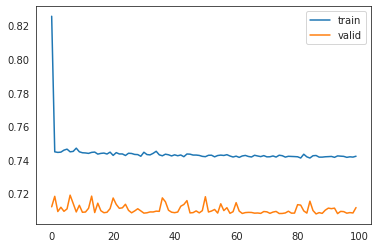

In [91]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

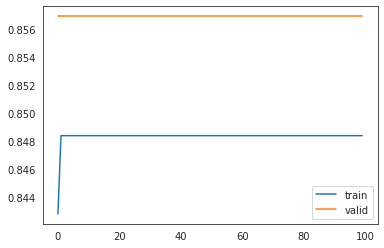

In [92]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train" , "valid") , loc =0)

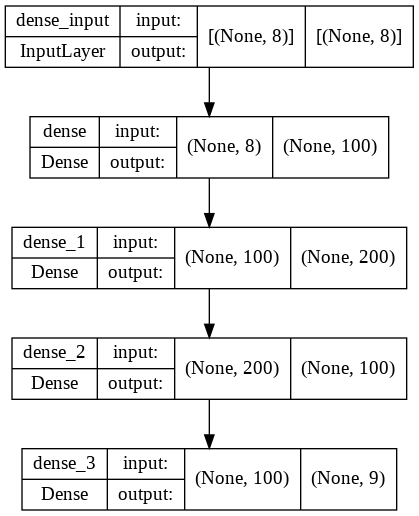

In [93]:
# Show the Model created
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# How loss moves around with each epoch
data_vis = [{'epoch': idx, 
         'loss': history.history['loss'][idx],  
         'val_loss': history.history['val_loss'][idx], 
         'accuracy': history.history['accuracy'][idx], 
         'val_accuracy': history.history['val_accuracy'][idx]
         } for idx in range(20)]
hip.Experiment.from_iterable(data_vis).display()

## Evaluation
Keras model can be evaluated with evaluate() function

Evaluation results are contained in a list

In [94]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.8569507002830505


In [95]:
results = model.evaluate(X_test, y_test)

70/70 [==============================] - 0s 2ms/step - loss: 0.7115 - accuracy: 0.8570


In [96]:
print(model.metrics_names)
print(results) 

['loss', 'accuracy']
[0.7115191221237183, 0.8569507002830505]


In [97]:
from sklearn.metrics import confusion_matrix

## Confusion Matrix

In [98]:
Y_pred_cls = model.predict(X_test)
print('Accuracy Model1 (Dropout): '+ str(model.evaluate(X_test,y_test)))

70/70 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.8570
Accuracy Model1 (Dropout): [0.7115191221237183, 0.8569507002830505]


'''
print('Recall_score: ' + str(recall_score(y_test.values,Y_pred_cls)))
print('Precision_score: ' + str(precision_score(y_test.values, Y_pred_cls,average='weighted')))
print('F-score: ' + str(f1_score(y_test.values,Y_pred_cls,average='weighted')))
#confusion_matrix(y_test.values, Y_pred_cls)
#recall and precision high, Our model doing well
'''

In [104]:
# Predict using Threshold - Increase Probability increase threshold
pred_y = model.predict(X_test)
y_pred = (pred_y > 0.8)
print('Accuracy Model1 (Dropout): '+ str(accuracy_score(y_test,y_pred)))

Accuracy Model1 (Dropout): 0.8569506726457399


In [105]:
str(model.evaluate(X_test,y_test)[1])

70/70 [==============================] - 0s 1ms/step - loss: 0.7115 - accuracy: 0.8570


'0.8569507002830505'

In [106]:
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

array([[1911,    0,    0,    0,    0,    0,    0,    0,    0],
       [  42,    0,    0,    0,    0,    0,    0,    0,    0],
       [  40,    0,    0,    0,    0,    0,    0,    0,    0],
       [  37,    0,    0,    0,    0,    0,    0,    0,    0],
       [  46,    0,    0,    0,    0,    0,    0,    0,    0],
       [  40,    0,    0,    0,    0,    0,    0,    0,    0],
       [  34,    0,    0,    0,    0,    0,    0,    0,    0],
       [  34,    0,    0,    0,    0,    0,    0,    0,    0],
       [  46,    0,    0,    0,    0,    0,    0,    0,    0]])

In [107]:
y_data

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [108]:
y_data.shape[1]

9

In [127]:
X_test[0]

array([0.02190089, 0.06630566, 0.6451266 , 0.09760138, 0.11762443,
       0.36608531, 0.64210192, 0.09623264])

In [137]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [144]:
raw_model ='/content/saved_models/anomaly_classification.hdf5'

In [145]:
from keras.models import load_model
model = load_model(raw_model)

In [146]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [148]:
test_data = X_test[0]

array([0.02190089, 0.06630566, 0.6451266 , 0.09760138, 0.11762443,
       0.36608531, 0.64210192, 0.09623264])

In [ ]:
###

In [153]:
test_data = np.expand_dims(X_test[0], axis = 0)

#predict the result
result = model.predict(test_data)

In [162]:
result[0]

array([0.8535674 , 0.01930571, 0.01838839, 0.01596997, 0.01941079,
       0.0200903 , 0.01821754, 0.01690639, 0.01814358], dtype=float32)

In [154]:
########
X_test[0]

array([0.02190089, 0.06630566, 0.6451266 , 0.09760138, 0.11762443,
       0.36608531, 0.64210192, 0.09623264])

In [157]:
Xnew = X_test[0].tolist()
Xnew

[0.021900892256695833,
 0.06630565574674228,
 0.6451265980747246,
 0.09760137964881281,
 0.11762443194939598,
 0.3660853109790173,
 0.6421019161675683,
 0.09623264222420141]

In [158]:
y_test[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report
rep = classification_report(y_test,y_pred)

In [164]:
from array import array

In [173]:
ip = np.array([[0.8535674 , 0.01930571, 0.01838839, 0.01596997, 0.01941079,0.0200903 , 0.01821754, 0.01690639, 0.01814358]])

In [175]:
from sklearn.metrics import classification_report
rep = classification_report(y_test,pred_y)

ValueError: ignored

In [174]:
Xnew = ip
# make a prediction
ynew = model.predict_classes(Xnew)
# show the inputs and predicted outputs
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

AttributeError: ignored